Code 'H35.3' not found. Try one of these: ['I69.810', 'I69.811', 'Z98.890, Z87.2']

Top 5 medical codes similar to H43.01:
- H27.8: (Score: 0.9949)
- H43.392: (Score: 0.8637)
- H43.11: (Score: 0.8543)
- H43.391: (Score: 0.8521)
- H43.823: (Score: 0.8516)

Running t-SNE on 2000 codes (this may take a minute)...


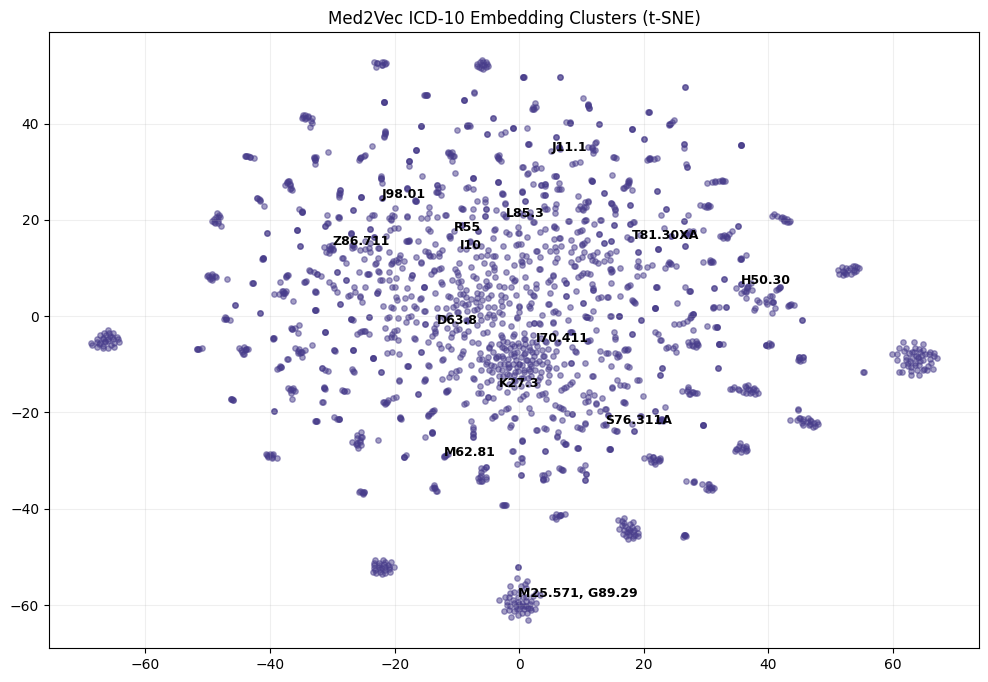

In [5]:
import torch
import torch.nn as nn
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# 1. Define the Architecture (Must match your training script)
class Med2VecPyTorch(nn.Module):
    def __init__(self, num_codes, emb_size, hidden_size, num_labels):
        super(Med2VecPyTorch, self).__init__()
        self.W_emb = nn.Linear(num_codes, emb_size)
        self.W_hidden = nn.Linear(emb_size, hidden_size)
        self.W_out = nn.Linear(hidden_size, num_labels)
        self.activation = nn.ReLU()

    def forward(self, x):
        emb = self.activation(self.W_emb(x))
        visit_rep = self.activation(self.W_hidden(emb))
        return visit_rep

# 2. Config (Must match your training)
NUM_X_CODES = 19882
EMB_SIZE = 100
HIDDEN_SIZE = 100
NUM_Y_CODES = 1518

# 3. Load Model and Dictionary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Med2VecPyTorch(NUM_X_CODES, EMB_SIZE, HIDDEN_SIZE, NUM_Y_CODES).to(device)
model.load_state_dict(torch.load("med2vec_final.pt", map_location=device))
model.eval()

with open('code_map.pkl', 'rb') as f:
    code_to_id = pickle.load(f, encoding='latin1')
id_to_code = {v: k for k, v in code_to_id.items()}

# 4. Extract Embeddings (W_emb weights)
# We transpose because Linear weights are (out_features, in_features)
embeddings = model.W_emb.weight.data.t().cpu().numpy()

# --- Similarity Function ---
def find_similar(query_code, top_k=5):
    if query_code not in code_to_id:
        print(f"Code '{query_code}' not found. Try one of these: {list(code_to_id.keys())[:3]}")
        return
    
    idx = code_to_id[query_code]
    query_vec = embeddings[idx]
    
    # Compute Cosine Similarity
    dot = np.dot(embeddings, query_vec)
    norm = np.linalg.norm(embeddings, axis=1) * np.linalg.norm(query_vec)
    similarity = dot / (norm + 1e-9)
    
    # Sort and get top matches
    nearest = similarity.argsort()[-(top_k+1):-1][::-1]
    
    print(f"\nTop {top_k} medical codes similar to {query_code}:")
    for i in nearest:
        print(f"- {id_to_code[i]}: (Score: {similarity[i]:.4f})")

# --- t-SNE Plotting Function ---
def plot_clusters(n_points=1500):
    print(f"\nRunning t-SNE on {n_points} codes (this may take a minute)...")
    tsne = TSNE(n_components=2, perplexity=30, init='pca', max_iter=1000, random_state=42)
    reduced = tsne.fit_transform(embeddings[:n_points])
    
    plt.figure(figsize=(12, 8))
    plt.scatter(reduced[:, 0], reduced[:, 1], alpha=0.5, s=15, c='darkslateblue')
    
    # Label a few codes to see the organization
    for i in range(0, n_points, 150):
        plt.annotate(id_to_code[i], (reduced[i, 0], reduced[i, 1]), fontsize=9, weight='bold')
        
    plt.title("Med2Vec ICD-10 Embedding Clusters (t-SNE)")
    plt.grid(True, alpha=0.2)
    plt.savefig("med2vec_visual.png")
    plt.show()

# 5. EXECUTION
# Let's test AMD (H35.3) and an eye code from your sample (H43.01)
find_similar('H35.3')
find_similar('H43.01') 
plot_clusters(n_points=2000)

Loading medical descriptions from CSV...
Running t-SNE on 2500 codes...


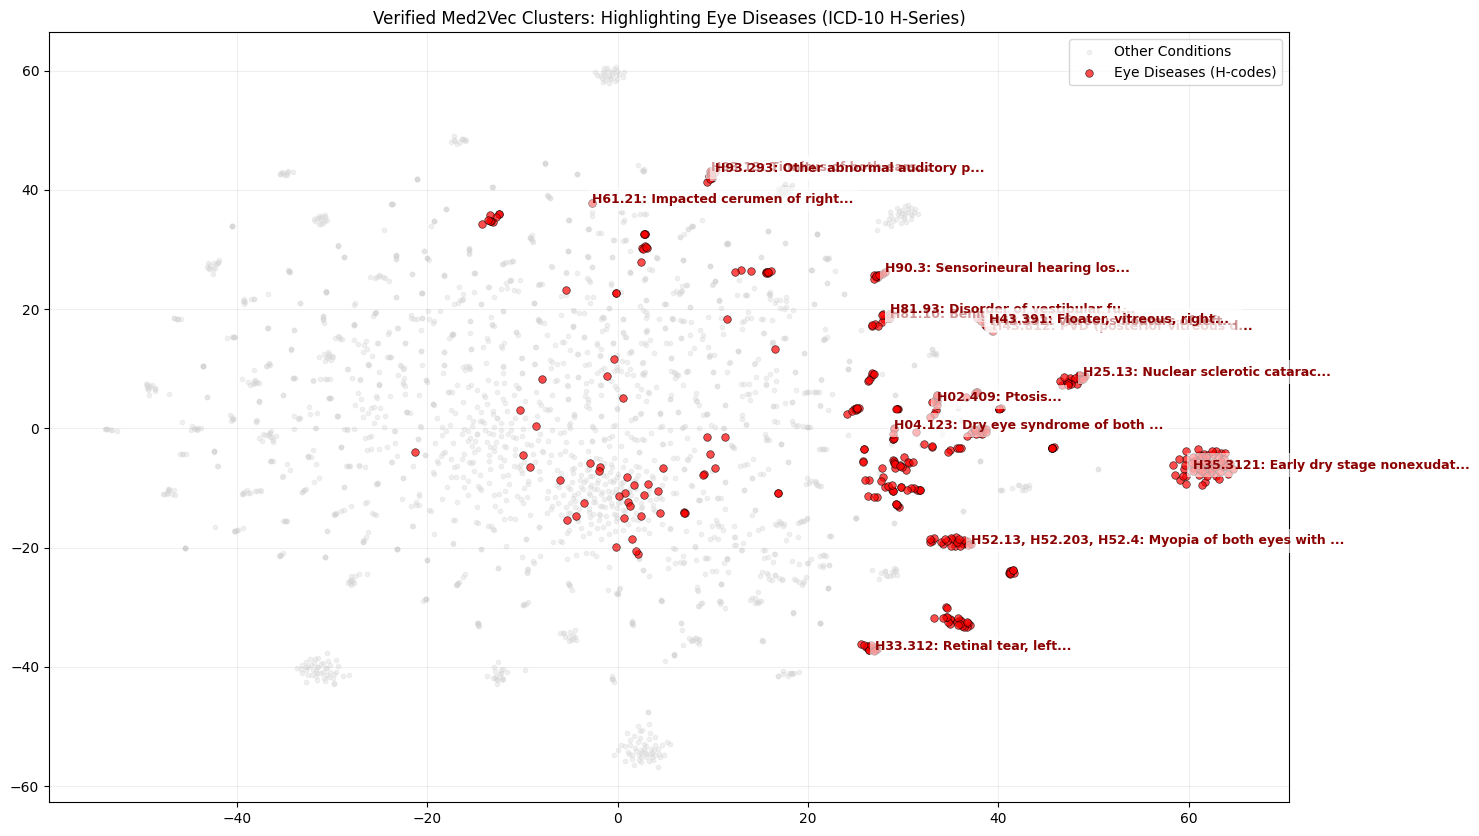

Plot saved as verified_eye_clusters.png


In [8]:
import torch
import torch.nn as nn
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# 1. Load your CSV for Descriptions
print("Loading medical descriptions from CSV...")
df = pd.read_csv('sorted_ICD_Data.csv')
# Create a dictionary mapping code -> description
# Adjust column names if they are different (e.g., 'ICD_DESCRIPTION')
desc_map = dict(zip(df['CURRENT_ICD10_LIST'].astype(str), df['DX_NAME']))

# 2. Architecture & Config (Must match your .pt file)
class Med2VecPyTorch(nn.Module):
    def __init__(self, num_codes, emb_size, hidden_size, num_labels):
        super(Med2VecPyTorch, self).__init__()
        self.W_emb = nn.Linear(num_codes, emb_size)
        self.W_hidden = nn.Linear(emb_size, hidden_size)
        self.W_out = nn.Linear(hidden_size, num_labels)
        self.activation = nn.ReLU()
    def forward(self, x):
        return self.activation(self.W_hidden(self.activation(self.W_emb(x))))

NUM_X_CODES, EMB_SIZE, HIDDEN_SIZE, NUM_Y_CODES = 19882, 100, 100, 1518
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 3. Load Weights and Dictionary
model = Med2VecPyTorch(NUM_X_CODES, EMB_SIZE, HIDDEN_SIZE, NUM_Y_CODES).to(device)
model.load_state_dict(torch.load("med2vec_final.pt", map_location=device))
model.eval()

with open('code_map.pkl', 'rb') as f:
    code_to_id = pickle.load(f, encoding='latin1')
id_to_code = {v: k for k, v in code_to_id.items()}
embeddings = model.W_emb.weight.data.t().cpu().numpy()

# 4. Run t-SNE
n_points = 2500 # Increase to see more of the landscape
print(f"Running t-SNE on {n_points} codes...")
tsne = TSNE(n_components=2, perplexity=40, init='pca', max_iter=1000, random_state=42)
low_dim = tsne.fit_transform(embeddings[:n_points])

# 5. Plot with Highlighting
plt.figure(figsize=(16, 10))

# Separate Eye codes (H) from others
eye_indices = [i for i in range(n_points) if id_to_code[i].startswith('H')]
other_indices = [i for i in range(n_points) if not id_to_code[i].startswith('H')]

# Plot others in light grey
plt.scatter(low_dim[other_indices, 0], low_dim[other_indices, 1], 
            c='lightgrey', alpha=0.3, s=10, label='Other Conditions')

# Plot Eye codes in Red
plt.scatter(low_dim[eye_indices, 0], low_dim[eye_indices, 1], 
            c='red', alpha=0.7, s=30, edgecolors='black', linewidth=0.5, label='Eye Diseases (H-codes)')

# 6. Annotate specific Eye codes to verify
# We label a few eye codes with their descriptions from the CSV
count = 0
for i in eye_indices:
    code = id_to_code[i]
    if count < 15: # Only label 15 to keep it readable
        description = desc_map.get(code, "No Description")
        plt.annotate(f"{code}: {description[:25]}...", 
                     (low_dim[i, 0], low_dim[i, 1]), 
                     fontsize=9, weight='bold', color='darkred',
                     bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
        count += 1

plt.title("Verified Med2Vec Clusters: Highlighting Eye Diseases (ICD-10 H-Series)")
plt.legend()
plt.grid(True, alpha=0.2)
plt.savefig("verified_eye_clusters.png", dpi=300)
plt.show()

print("Plot saved as verified_eye_clusters.png")

Computing UMAP projection...


/home/surya/miniconda3/envs/pcia_modern/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


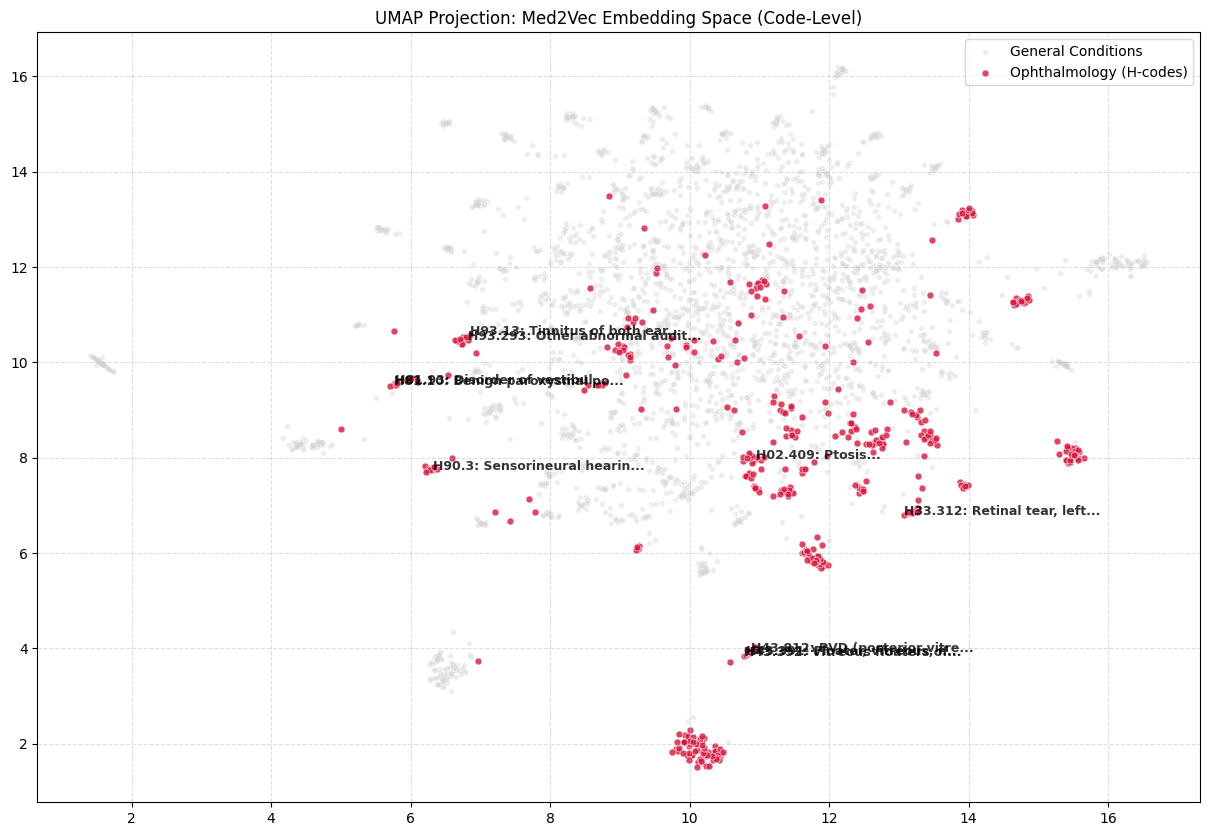

UMAP visualization saved to Visualisations/med2vec_umap_clusters.png


In [3]:
import os
import torch
import torch.nn as nn
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import umap

# --- 1. DEFINE PATHS BASED ON YOUR TREE ---
# Assuming you are running this from ~/PCIA/med2vec/
base_path = "."
data_path = "../Dataset/sorted_ICD_Data.csv"
model_path = "model/med2vec_final.pt"
dict_path = "required_inputs/code_map.pkl"
output_folder = "Visualisations"

# Ensure the folder exists
os.makedirs(output_folder, exist_ok=True)

# --- 2. ARCHITECTURE ---
class Med2VecPyTorch(nn.Module):
    def __init__(self, num_codes, emb_size, hidden_size, num_labels):
        super(Med2VecPyTorch, self).__init__()
        self.W_emb = nn.Linear(num_codes, emb_size)
        self.W_hidden = nn.Linear(emb_size, hidden_size)
        self.W_out = nn.Linear(hidden_size, num_labels)
        self.activation = nn.ReLU()
    def forward(self, x):
        return self.activation(self.W_hidden(self.activation(self.W_emb(x))))

# --- 3. LOADING ---
NUM_X_CODES, EMB_SIZE, HIDDEN_SIZE, NUM_Y_CODES = 19882, 100, 100, 1518
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Med2VecPyTorch(NUM_X_CODES, EMB_SIZE, HIDDEN_SIZE, NUM_Y_CODES).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

with open(dict_path, 'rb') as f:
    code_to_id = pickle.load(f, encoding='latin1')
id_to_code = {v: k for k, v in code_to_id.items()}
embeddings = model.W_emb.weight.data.t().cpu().numpy()

# Load descriptions for annotation
df_desc = pd.read_csv(data_path)
desc_map = dict(zip(df_desc['CURRENT_ICD10_LIST'].astype(str), df_desc['DX_NAME']))

# --- 4. RUN UMAP ---
print("Computing UMAP projection...")
# Use 'cosine' metric to match the Med2Vec objective
reducer = umap.UMAP(n_neighbors=30, min_dist=0.3, metric='cosine', random_state=42)
embedding_2d = reducer.fit_transform(embeddings[:3000]) # Visualizing first 3000 codes

# --- 5. PLOTTING ---
plt.figure(figsize=(15, 10))

# Identify Eye Codes
eye_mask = [id_to_code[i].startswith('H') for i in range(3000)]
other_mask = [not x for x in eye_mask]

# Plot background
plt.scatter(embedding_2d[other_mask, 0], embedding_2d[other_mask, 1], 
            c='lightgrey', s=8, alpha=0.3, label='General Conditions')

# Plot Eye clusters
plt.scatter(embedding_2d[eye_mask, 0], embedding_2d[eye_mask, 1], 
            c='crimson', s=25, alpha=0.8, edgecolors='white', linewidth=0.5, label='Ophthalmology (H-codes)')

# Annotated Verification
labeled = 0
for i in range(3000):
    code = id_to_code[i]
    if code.startswith('H') and labeled < 10:
        plt.annotate(f"{code}: {desc_map.get(code, '')[:20]}...", 
                     (embedding_2d[i, 0], embedding_2d[i, 1]),
                     fontsize=9, fontweight='bold', alpha=0.8)
        labeled += 1

plt.title("UMAP Projection: Med2Vec Embedding Space (Code-Level)")
plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.4)

# --- 6. SAVE ---
save_name = os.path.join(output_folder, "med2vec_umap_clusters.png")
plt.savefig(save_name, dpi=300, bbox_inches='tight')
plt.show()

print(f"UMAP visualization saved to {save_name}")